In [1]:
import numpy as np

import cv2
from statistics import median_high
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, ZeroPadding2D,Activation, AveragePooling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score

2025-04-29 16:16:45.517197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745943405.709535      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745943405.764571      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path_train = "/kaggle/input/brainmri/Datasest Merged 1/Datasest Merged 1"

In [3]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = {}
for i, classes in enumerate(class_names, start=0):
  class_labels[classes] = i

In [4]:
image_size = (130, 130)

In [5]:
#For Training data

train_data = []
train_labels = []

for folder in os.listdir(path_train):
    print("In folder: {}".format(folder))
    for file in os.listdir(os.path.join(path_train, folder)):
        image_path = os.path.join(path_train, folder, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, image_size)  # Resize the image using image_size
        train_data.append(image)
        train_labels.append(class_labels[folder])

train_data = np.array(train_data, dtype='float32')
train_labels = np.array(train_labels, dtype='int32')

train_data = train_data / 255.0 

In folder: pituitary
In folder: notumor
In folder: meningioma
In folder: glioma


In [6]:
train_data[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.01176471,
        0.00392157],
       ...,
       [0.00392157, 0.00784314, 0.00392157, ..., 0.00784314, 0.01176471,
        0.01176471],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

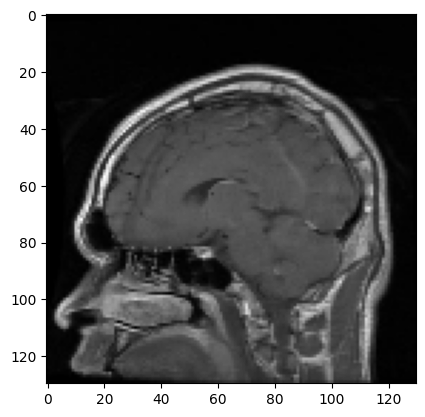

In [7]:
plt.imshow(train_data[0], cmap='gray')

In [8]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_labels)
labels_encoded = to_categorical(labels_encoded)

# Print the mapping of labels to their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 0, 1: 1, 2: 2, 3: 3}


In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=42, shuffle=True)

# Convert to numpy arrays and reshape
X_train = np.array(X_train).reshape(-1, 130, 130, 1)
X_test = np.array(X_test).reshape(-1, 130, 130, 1)

# Define number of classes
num_classes = len(np.unique(train_labels))

print(num_classes)

4


In [10]:
# Resize images before converting to numpy arrays
X_train_resized = np.array([cv2.resize(img, (156, 156)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (156, 156)) for img in X_test])

# Reshape
X_train_resized = X_train_resized.reshape(-1, 156, 156, 1)
X_test_resized = X_test_resized.reshape(-1, 156, 156, 1)


In [11]:
import numpy as np
print("y_train classes:", np.unique(y_train))
print("y_test classes:", np.unique(y_test))

y_train classes: [0 1 2 3]
y_test classes: [0 1 2 3]


In [12]:
import keras
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=4)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=4)

# Verify the shape (should be (n_samples, 4) for both)
print("y_train_categorical shape:", y_train_categorical.shape)
print("y_test_categorical shape:", y_test_categorical.shape)

y_train_categorical shape: (9345, 4)
y_test_categorical shape: (4006, 4)


# DenseNet-169

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, concatenate,
                                     AveragePooling2D, GlobalAveragePooling2D, Dense, MaxPooling2D, ZeroPadding2D)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def conv_block(x, growth_rate, name):
    """A building block for a dense block."""
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = concatenate([x, x1], axis=bn_axis, name=name + '_concat')
    return x

def transition_block(x, reduction, name):
    """A transition block."""
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def dense_block(x, blocks, name):
    """A dense block."""
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def DenseNet169(input_shape=(130, 130, 1), classes=4):
    """Instantiates the DenseNet-169 architecture."""
    img_input = Input(shape=input_shape)
    
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    
    x = ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = Conv2D(64, 7, strides=2, use_bias=False, name='conv1_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = MaxPooling2D(3, strides=2, name='pool1')(x)
    
    x = dense_block(x, 6, name='conv2')   # 6 conv blocks
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, 12, name='conv3')  # 12 conv blocks
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, 32, name='conv4')  # 24 -> 32 conv blocks
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, 32, name='conv5')  # 16 -> 32 conv blocks
    
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)
    
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='fc')(x)
    
    # Create model
    model = Model(img_input, x, name='densenet169')
    
    return model

# Instantiate the model
DenseNet169_model = DenseNet169(input_shape=(130, 130, 1), classes=4)

# Optional: Display model summary
DenseNet169_model.summary()

Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 130, 130, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_10         │ (None, 136, 136, 1)    │              0 │ input_layer_5[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 65, 65, 64)     │          3,136 │ zero_padding2d_10[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 65, 65, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 65, 65, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_11         │ (None, 67, 67, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 33, 33, 64)     │              0 │ zero_padding2d_11[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 33, 33, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 33, 33, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 33, 33, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 33, 33, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 33, 33, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 33, 33, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 33, 33, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 12,643,268 (48.23 MB)

 Trainable params: 12,484,868 (47.63 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [34]:
DenseNet169_model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history1 = DenseNet169_model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4787 - loss: 1.2187
Epoch 1: val_accuracy improved from -inf to 0.26378, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 408s 763ms/step - accuracy: 0.4791 - loss: 1.2181 - val_accuracy: 0.2638 - val_loss: 1.8880
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6812 - loss: 0.8179
Epoch 2: val_accuracy improved from 0.26378 to 0.34724, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.6813 - loss: 0.8176 - val_accuracy: 0.3472 - val_loss: 1.9658
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7835 - loss: 0.6091
Epoch 3: val_accuracy improved from 0.34724 to 0.41948, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.7835 - loss: 0.6090 - val_accuracy: 0.4195 - val_loss: 1.3013
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8320 - loss: 0.4795
Epoch 4: val_accuracy i

# DenseNet-169 With EfficientNet Capabilities

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, concatenate,
                                     AveragePooling2D, GlobalAveragePooling2D, Dense, MaxPooling2D, ZeroPadding2D)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def conv_block(x, growth_rate, name):
    """A building block for a dense block."""
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = concatenate([x, x1], axis=bn_axis, name=name + '_concat')
    return x

def transition_block(x, reduction, name):
    """A transition block."""
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def dense_block(x, blocks, name):
    """A dense block."""
    for i in range(blocks):
        x = conv_block(x, 38, name=name + '_block' + str(i + 1))  # Growth rate: 32 -> 38
    return x

def DenseNet169_Scaled(input_shape=(156, 156, 1), classes=4):
    """DenseNet-169 with scaled parameters but original layer counts."""
    img_input = Input(shape=input_shape)
    
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    
    x = ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = Conv2D(77, 7, strides=2, use_bias=False, name='conv1_conv')(x)  # 64 * 1.2 = 77
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = MaxPooling2D(3, strides=2, name='pool1')(x)
    
    # Original DenseNet-169 block counts
    x = dense_block(x, 6, name='conv2')   # 6 blocks
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, 12, name='conv3')  # 12 blocks
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, 32, name='conv4')  # 32 blocks
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, 32, name='conv5')  # 32 blocks
    
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)
    
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(2458, activation='relu', name='fc_dense')(x)  # 2048 * 1.2 = 2458
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Dense(classes, activation='softmax', name='fc_output')(x)
    
    # Create model
    model = Model(img_input, x, name='densenet169_scaled')
    
    return model

# Instantiate the model
model_DenseNet169_scaled = DenseNet169_Scaled(input_shape=(156, 156, 1), classes=4)

In [ ]:
model_DenseNet169_scaled.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history2 = model_DenseNet169_scaled_dense.fit(X_train_resized, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5289 - loss: 1.1005   
Epoch 1: val_accuracy improved from -inf to 0.29856, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - accuracy: 0.5293 - loss: 1.0997 - val_accuracy: 0.2986 - val_loss: 3.2211
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.7895 - loss: 0.5992
Epoch 2: val_accuracy did not improve from 0.29856
234/234 ━━━━━━━━━━━━━━━━━━━━ 129s 552ms/step - accuracy: 0.7896 - loss: 0.5989 - val_accuracy: 0.1247 - val_loss: 3.0115
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8720 - loss: 0.3742
Epoch 3: val_accuracy did not improve from 0.29856
234/234 ━━━━━━━━━━━━━━━━━━━━ 127s 544ms/step - accuracy: 0.8720 - loss: 0.3742 - val_accuracy: 0.2638 - val_loss: 3.1951
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9176 - loss: 0.2465
Epoch 4: val_accuracy improved from 0.29856 to 0.81755, saving model to best_model.keras
234/234 ━━━

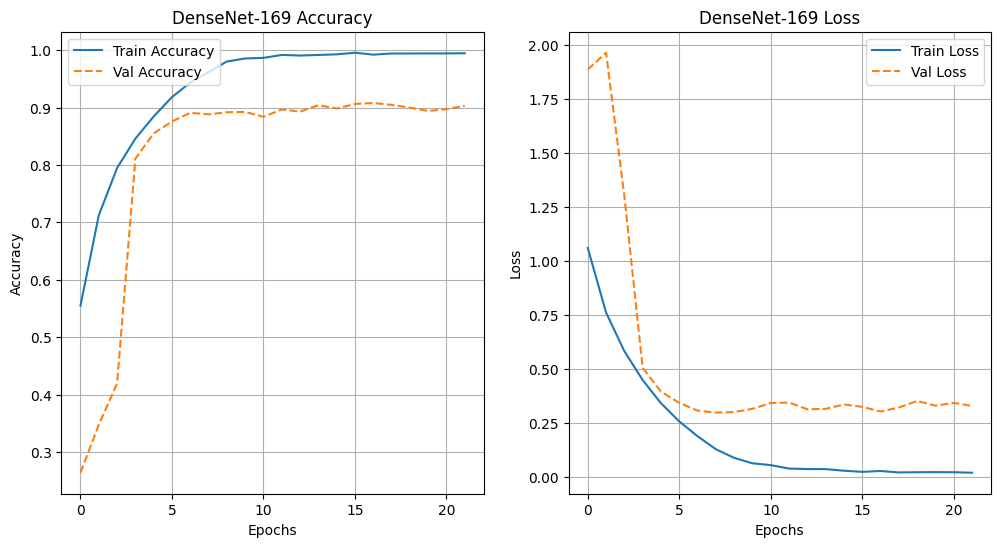

In [42]:
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('DenseNet-169 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('DenseNet-169 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

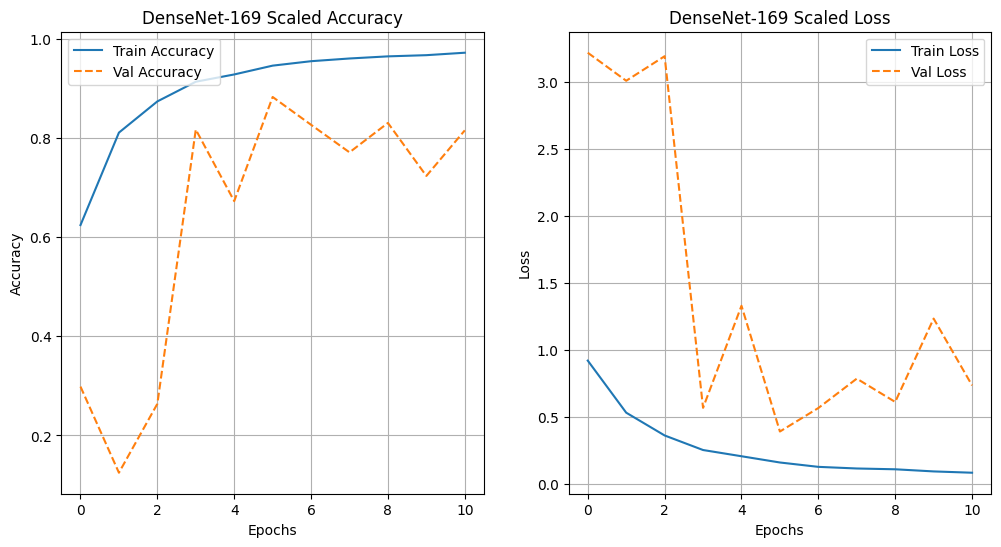

In [43]:
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('DenseNet-169 Scaled Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('DenseNet-169 Scaled Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Function to calculate specificity and sensitivity for multi-class
def specificity_score_multiclass(conf_matrix):
    specificity_per_class = []
    sensitivity_per_class = []
    
    for i in range(conf_matrix.shape[0]):  # Loop through each class
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
        tp = conf_matrix[i, i]
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        specificity_per_class.append(specificity)
        sensitivity_per_class.append(sensitivity)
    
    return specificity_per_class, sensitivity_per_class

# Function to print model metrics and confusion matrix
def print_model_metrics(y_true, y_pred, model_name, class_names):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Compute specificity and sensitivity for each class
    specificity, sensitivity = specificity_score_multiclass(conf_matrix)
    
    # Print metrics
    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: Specificity: {specificity[i]:.4f}, Sensitivity: {sensitivity[i]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Function to plot one image per class with predicted and true labels
def plot_sample_images_per_class(X, y_true, y_pred, class_names):
    plt.figure(figsize=(12, 8))
    
    shown_classes = set()
    class_indices = {}

    # Find one index per class
    for idx, label in enumerate(y_true):
        if label not in shown_classes:
            class_indices[label] = idx
            shown_classes.add(label)
        if len(shown_classes) == len(class_names):
            break

    for i, (label, idx) in enumerate(class_indices.items()):
        image = X[idx]
        if image.shape[-1] == 1:  # Grayscale
            image = image.squeeze()
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")

    plt.suptitle("Sample Image Per Class with Prediction")
    plt.tight_layout()
    plt.show()

# Define your actual class names
class_names = ["Pituitary", "No Tumor", "Meningioma", "Glioma"]



126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 166ms/step

Metrics for DenseNet-169:
Accuracy: 0.9079
Precision: 0.9086
Recall: 0.9079
F1 Score: 0.9080

Pituitary: Specificity: 0.9458, Sensitivity: 0.8725
No Tumor: Specificity: 0.9511, Sensitivity: 0.8796
Meningioma: Specificity: 0.9929, Sensitivity: 0.9960
Glioma: Specificity: 0.9845, Sensitivity: 0.9117


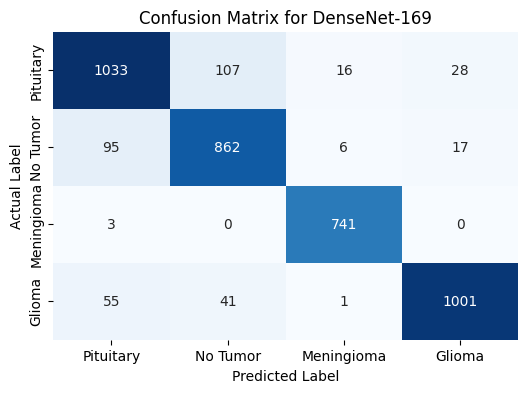


Classification Report:
              precision    recall  f1-score   support

   Pituitary       0.87      0.87      0.87      1184
    No Tumor       0.85      0.88      0.87       980
  Meningioma       0.97      1.00      0.98       744
      Glioma       0.96      0.91      0.93      1098

    accuracy                           0.91      4006
   macro avg       0.91      0.91      0.91      4006
weighted avg       0.91      0.91      0.91      4006



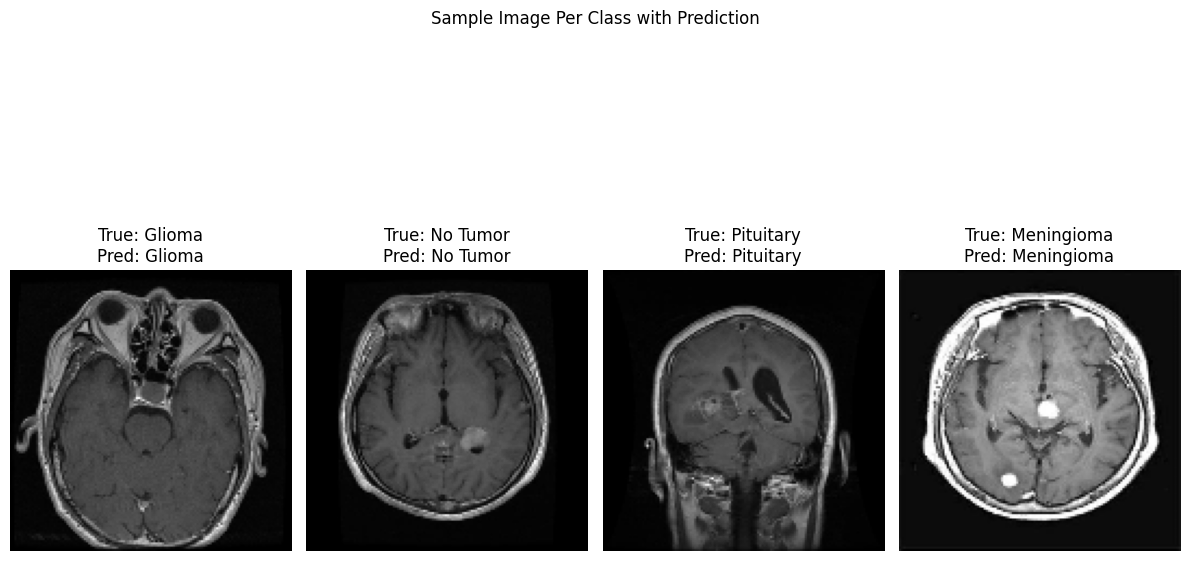

In [ ]:
# Get predictions from your trained model
y_pred1 = np.argmax(DenseNet169_model.predict(X_test), axis=1)
y_true1 = y_test  # Assuming it's label-encoded already

# Show metrics and plots
print_model_metrics(y_true1, y_pred1, 'DenseNet-169', class_names)
plot_sample_images_per_class(X_test, y_true1, y_pred1, class_names)


126/126 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step

Metrics for DenseNet-169 Scaled:
Accuracy: 0.8914
Precision: 0.8945
Recall: 0.8914
F1 Score: 0.8913

Pituitary: Specificity: 0.9337, Sensitivity: 0.9383
No Tumor: Specificity: 0.9570, Sensitivity: 0.8112
Meningioma: Specificity: 0.9991, Sensitivity: 0.8629
Glioma: Specificity: 0.9605, Sensitivity: 0.9317


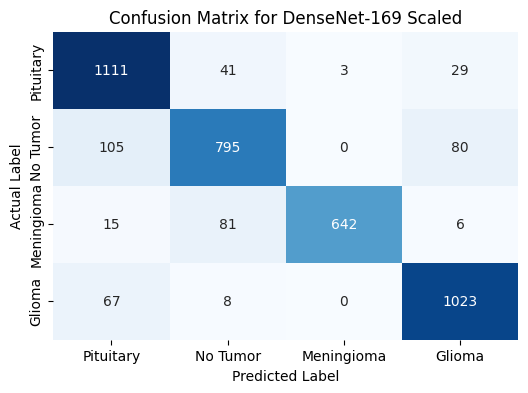


Classification Report:
              precision    recall  f1-score   support

   Pituitary       0.86      0.94      0.90      1184
    No Tumor       0.86      0.81      0.83       980
  Meningioma       1.00      0.86      0.92       744
      Glioma       0.90      0.93      0.92      1098

    accuracy                           0.89      4006
   macro avg       0.90      0.89      0.89      4006
weighted avg       0.89      0.89      0.89      4006



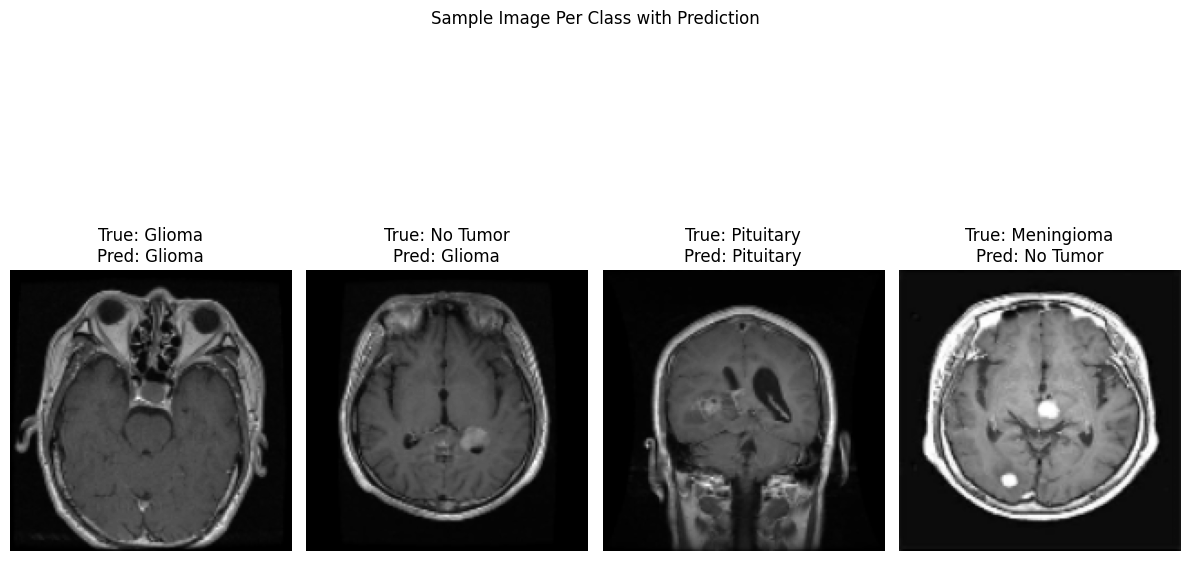

In [ ]:
# Get predictions from your trained model
y_pred1 = np.argmax(model_DenseNet169_scaled.predict(X_test_resized), axis=1)
y_true1 = y_test  # Assuming it's label-encoded already

# Show metrics and plots
print_model_metrics(y_true1, y_pred1, 'DenseNet-169 Scaled', class_names)
plot_sample_images_per_class(X_test_resized, y_true1, y_pred1, class_names)
